In [2]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
import os
os.environ["GDAL_DATA"] = "/home/parndt/anaconda3/envs/geo_py37/share/gdal"
os.environ["PROJ_LIB"] = "/home/parndt/anaconda3/envs/geo_py37/share/proj"
import h5py
import math
# import datetime
import zipfile
import traceback
import shapely
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
from cmcrameri import cm as cmc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image, display
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
from sklearn.neighbors import KDTree
from scipy.stats import binned_statistic
from scipy.signal import find_peaks

from lakeanalysis.utils import dictobj, convert_time_to_string, read_melt_lake_h5
from lakeanalysis.S2lakes import plot_IS2lake_imagery
from lakeanalysis.nsidc import download_is2
from icelakes.nsidc import download_granule
from icelakes.detection import read_atl03
from ed.edcreds import getedcreds

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## calculate percentage of ground track that was identified as lakes

In [ ]:
# stats_column_names=['region', 'granule', 'xatc_total', 'xatc_lakes', 'nphot_total', 'nphot_lakes']
# dfstats = pd.read_csv('stats_combined_GLD2_except91granules.csv',header=None, names=stats_column_names)
# dfl = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
# dfstats['basin'] = dfstats.apply(lambda x: x.region.split('_')[-1].replace('.geojson', ''), axis=1)
# df = dfstats[(dfstats.basin=='B-C') | (dfstats.basin=='CW')].copy()
# df = df[~np.isnan(df.xatc_total)]
# df['melt_season'] = 'none'
# df.loc[df.basin == 'CW','melt_season'] = df[df.basin == 'CW'].apply(lambda x: x.granule[6:10], axis=1)
# df.loc[df.basin == 'B-C','melt_season'] = df[df.basin == 'B-C'].apply(
#     lambda x: 
#     '%s-%s' % (int(x.granule[6:10]), int(x.granule[8:10])+1) 
#     if int(x.granule[10:12])>7 else 
#     '%s-%s' % (int(x.granule[6:10])-1, int(x.granule[8:10])),
#     axis=1)
# df = df[(df.melt_season=='2018-19') | (df.melt_season=='2020-21') | (df.melt_season=='2019') | (df.melt_season=='2020')]
# granulelist = list(df.granule)
# dfl['granule_in_stats'] = dfl.apply(lambda x: x.granule_id in granulelist, axis=1)
# print('%d %% of lakes are in granules for which stats were reported' % (100*np.mean(dfl.granule_in_stats)))
# df = df[['basin', 'melt_season', 'granule', 'region', 'xatc_total', 'nphot_total']].sort_values(by='granule').reset_index(drop=True)
# df.to_csv('data/granule_stats_totals_methods.csv', index=False)

In [ ]:
dfl = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
df = pd.read_csv('data/granule_stats_totals_methods.csv')

In [ ]:
# mergecol = 'description'
# statcols = ['xatc_total', 'nphot_total']
# groupcol = 'melt_season'
# df1 = df.groupby(by=groupcol)[statcols].sum().reset_index().rename(columns={groupcol: mergecol})
# groupcol = 'basin'
# df2 = df.groupby(by=groupcol)[statcols].sum().reset_index().rename(columns={groupcol: mergecol})
# df2.loc[len(df2)] = ['total'] + list(df[statcols].sum())
# summary_totals = pd.concat((df1, df2)).reset_index(drop=True)
# summary_totals[mergecol] = summary_totals[mergecol].astype(str)
# statcols = ['length_water_surfaces', 'n_photons_where_water']
# groupcol = 'melt_season'
# df1 = dfl.groupby(by=groupcol)[statcols].sum().reset_index().rename(columns={groupcol: mergecol})
# groupcol = 'basin_name'
# df2 = dfl.groupby(by=groupcol)[statcols].sum().reset_index().rename(columns={groupcol: mergecol})
# df2.loc[len(df2)] = ['total'] + list(dfl[statcols].sum())
# summary_lakes = pd.concat((df1, df2)).reset_index(drop=True)
# summary_lakes[mergecol] = summary_lakes[mergecol].astype(str)
# summary = pd.merge(summary_totals, summary_lakes, left_on=mergecol, right_on=mergecol)
# summary['percentage_xatc'] = summary.length_water_surfaces / summary.xatc_total * 100
# summary['percentage_phot'] = summary.n_photons_where_water / summary.nphot_total * 100
# summary.to_csv('data/summary_stats_methods.csv', index=False)
# summary

In [ ]:
summary = pd.read_csv('data/summary_stats_methods.csv')
summary

## get numbers of lakes (including SuRRF high-quality only)

In [ ]:
dfl = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
dfl['qual_nonzero'] = ['good data' if (x > 0) else 'bad data' for x in dfl.lake_quality]

In [ ]:
sheet_totals = dfl.groupby(by='ice_sheet')[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
sheet_totals

In [ ]:
total_counts = dfl.groupby(by='qual_nonzero')[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
total_counts

In [ ]:
sheet_counts = dfl.groupby(by=['ice_sheet','qual_nonzero'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
sheet_counts['percent'] = np.nan
for sheet in ['AIS', 'GrIS']:
    sheet_counts.loc[sheet, 'percent'] = np.array(sheet_counts.loc[sheet].lake_count / sheet_counts.loc[sheet].lake_count.sum() * 100)
sheet_counts['percent'] = sheet_counts.apply(lambda x: '%.1f %%' % x.percent, axis=1)
sheet_counts

In [ ]:
dfl.groupby(by=['ice_sheet','melt_season'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})
dfl.groupby(by=['ice_sheet','melt_season','qual_nonzero'])[['lake_id']].count().rename(columns={'lake_id': 'lake_count'})

In [ ]:
dfl['count_nnz'] = dfl.apply(lambda x: 1 if (x.lake_quality > 0) else 0, axis=1)
grp = dfl.groupby(by=['ice_sheet','melt_season'])[['count_nnz']]
dfp = grp.sum()
dfp['total']= grp.count()
dfp['perc_good'] = dfp.apply(lambda x: '%d %%' % np.round((x.count_nnz / x.total) * 100), axis=1)
dfp

In [ ]:
fn_thresh = 'basins/shapefiles/ANT_basins_thresh1000.shp'
ant_gdf_thresh = gpd.read_file(fn_thresh)

fn_thresh = 'basins/shapefiles/GRE_basins_thresh2000.shp'
gre_gdf_thresh = gpd.read_file(fn_thresh)

print('CW_2000: %d km^2' % np.round(gre_gdf_thresh.area.sum() / 1e6))
print('BC_1000: %d km^2' % np.round(ant_gdf_thresh.area.sum() / 1e6))

## get the number of lakes overlapping with maximum lake extent

In [ ]:
# from shapely.geometry import Point, LineString
# def get_gt_lonlat(x):
#     d = dictobj(read_melt_lake_h5(x.file_name)).depth_data
#     return LineString([(d.lon.iloc[0], d.lat.iloc[0]), (d.lon.iloc[-1], d.lat.iloc[-1])])
# dfl = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
# geom = dfl.apply(get_gt_lonlat, axis=1)

# gdfl = gpd.GeoDataFrame(dfl, geometry=geom, crs="EPSG:4326")
# gdfl['intersects_with_extent'] = False

# regions = ['CW', 'B-C']
# for region in regions:
    
#     if region == 'B-C':
#         region_name = 'Amery Catchment'
#         base_crs = 'EPSG:3031'
#         meltseasons = ['2018-19', '2020-21']
#     if region == 'CW':
#         region_name = 'Central West Greenland'
#         base_crs = 'EPSG:3413'
#         meltseasons = ['2019', '2020']
    
#     for i, meltseason in enumerate(meltseasons):
#         selector_season = (gdfl.basin_name == region) & (gdfl.melt_season == meltseason)
#         gdf_season = gdfl[selector_season]
#         ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region, meltseason.replace('-','_')), 
#                             crs='EPSG:4326').to_crs(base_crs).dissolve()
#         does_intersect = gdf_season.to_crs(ext.crs).geometry.intersects(ext.geometry.iloc[0])
#         gdfl.loc[selector_season, 'intersects_with_extent'] = does_intersect
#         print(region, meltseason, '%.3f%%' % (np.mean(does_intersect)*100))

In [ ]:
# CW 2019 96.000%
# CW 2020 95.429%
# B-C 2018-19 93.056%
# B-C 2020-21 71.429%

In [ ]:
# gdfl.to_csv('data/lakestats_methods_paper_depth_update_gtextents.csv', index=False)

In [9]:
from shapely import wkt
df = pd.read_csv('data/lakestats_methods_paper_depth_update_gtextents.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)
gdfl = gpd.GeoDataFrame(df, crs='epsg:4326')
print(gdfl.groupby(by=['ice_sheet'])[['intersects_with_extent']].mean()*100)

           intersects_with_extent
ice_sheet                        
AIS                     92.245989
GrIS                    95.800000


In [10]:
dfl_qual = gdfl[gdfl.lake_quality>0].copy()
print(gdfl.intersects_with_extent.mean())
print(dfl_qual.intersects_with_extent.mean())
print(dfl_qual.groupby(by=['ice_sheet'])[['intersects_with_extent']].mean()*100)
dfl_qual.groupby(by=['ice_sheet','melt_season'])[['intersects_with_extent']].mean()*100

0.936698717948718
0.9660297239915074
           intersects_with_extent
ice_sheet                        
AIS                     95.783133
GrIS                    97.049180


intersects_with_extent
ice_sheet melt_season                        
AIS       2018-19                   96.341463
          2020-21                   50.000000
GrIS      2019                      96.428571
          2020                      98.165138

# TODO: get the numbers and percentages for this!

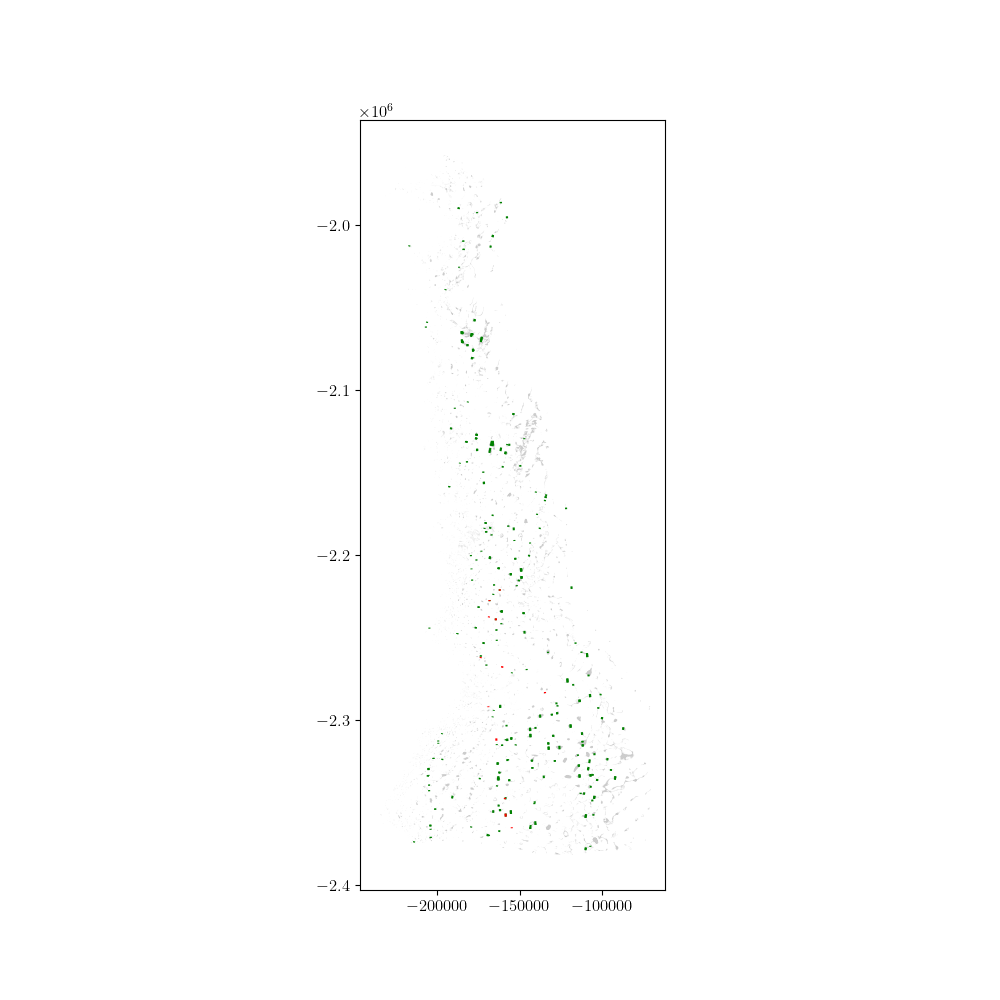

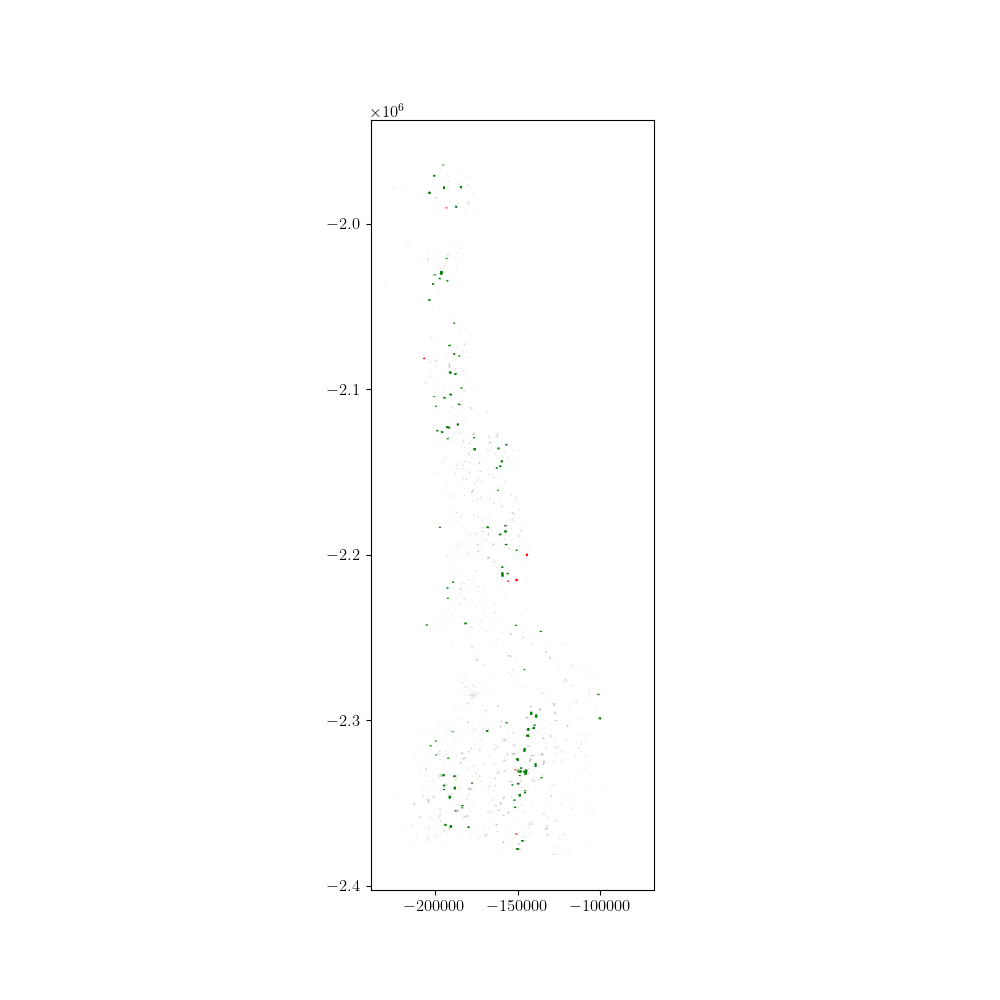

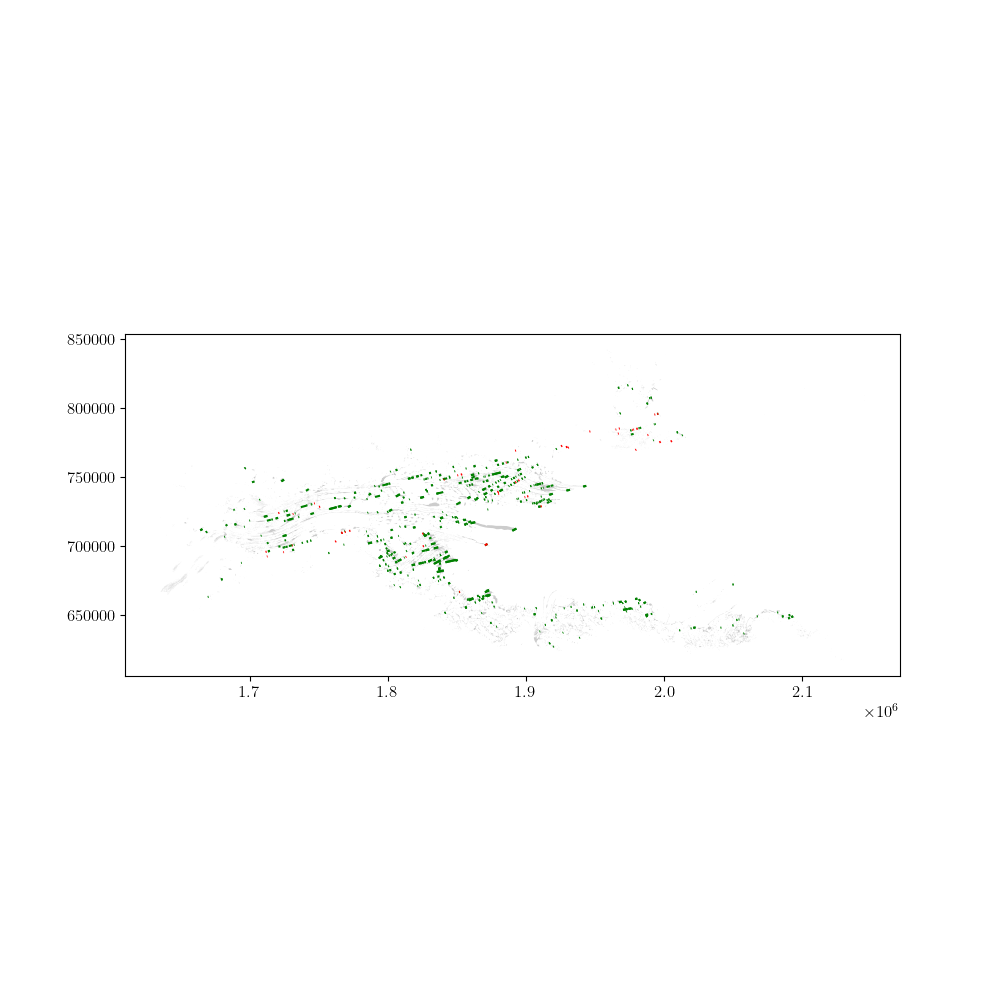

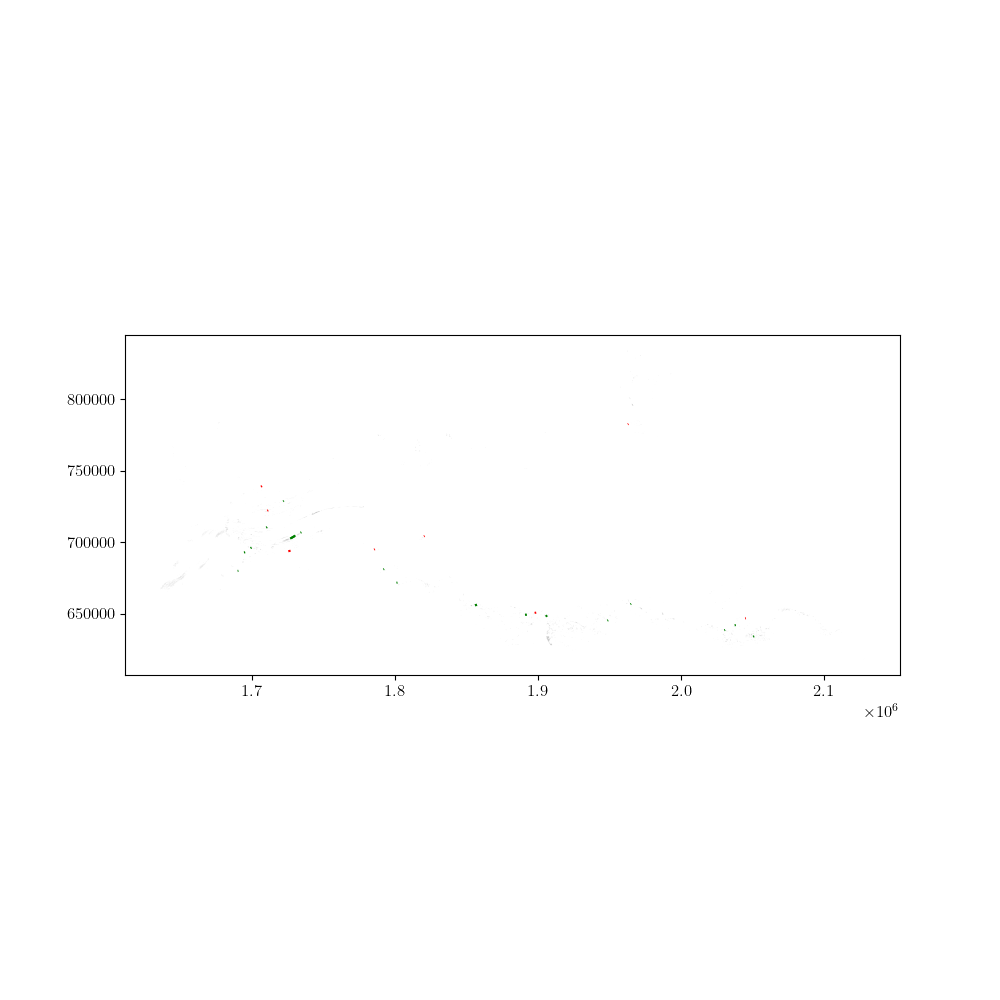

In [14]:
regions = ['CW', 'B-C']
for region in regions:
    
    if region == 'B-C':
        region_name = 'Amery Catchment'
        base_crs = 'EPSG:3031'
        meltseasons = ['2018-19', '2020-21']
    if region == 'CW':
        region_name = 'Central West Greenland'
        base_crs = 'EPSG:3413'
        meltseasons = ['2019', '2020']
    
    for i, meltseason in enumerate(meltseasons):
        selector_season = (gdfl.basin_name == region) & (gdfl.melt_season == meltseason)
        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region, meltseason.replace('-','_')), 
                            crs='EPSG:4326').to_crs(base_crs)
        gdf_season = gdfl[selector_season].to_crs(ext.crs)
        fig, ax = plt.subplots(figsize=[10,10])
        ext.plot(ax=ax,color=[0.8]*3)
        gdf_season[gdf_season.intersects_with_extent].plot(color='g',ax=ax)
        gdf_season[~gdf_season.intersects_with_extent].plot(color='r',ax=ax)
        fig.savefig('zzz_testplot_meltextent_overlaps.jpg', dpi=600)

plotting ground track


/Users/parndt/anaconda3/envs/eeicelakes-env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


plotting ground track


/Users/parndt/anaconda3/envs/eeicelakes-env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


plotting ground track


/Users/parndt/anaconda3/envs/eeicelakes-env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


plotting ground track


/Users/parndt/anaconda3/envs/eeicelakes-env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


plotting ground track


/Users/parndt/anaconda3/envs/eeicelakes-env/lib/python3.10/site-packages/matplotlib/ticker.py:2937: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


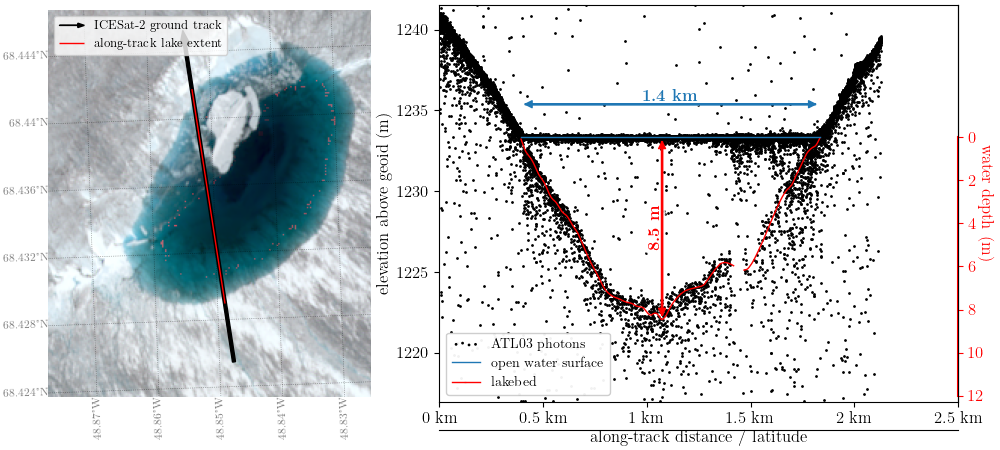

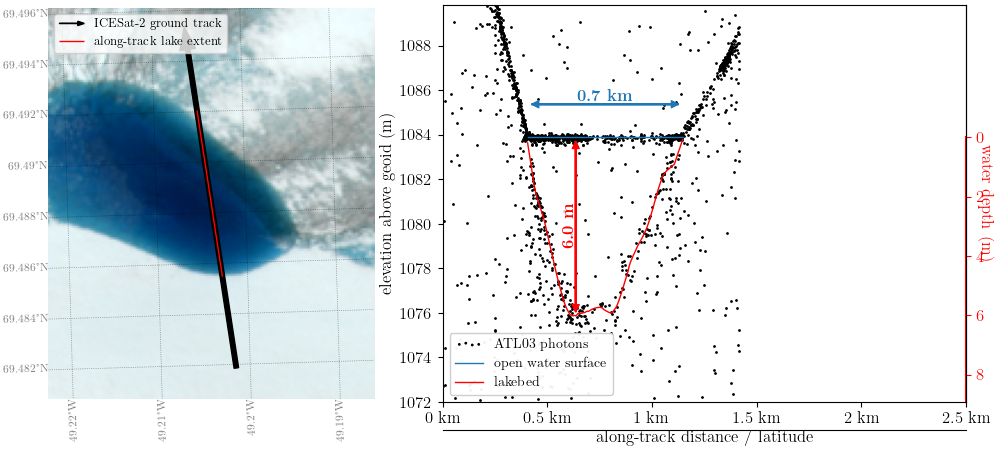

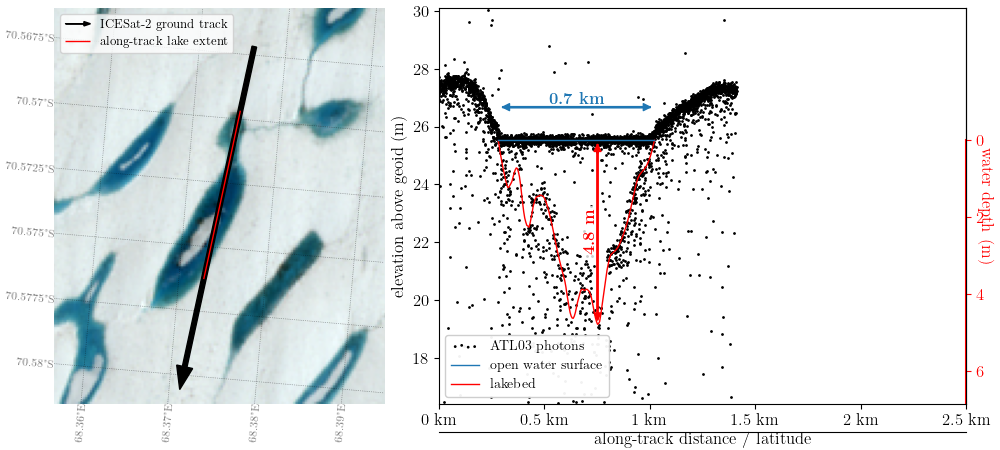

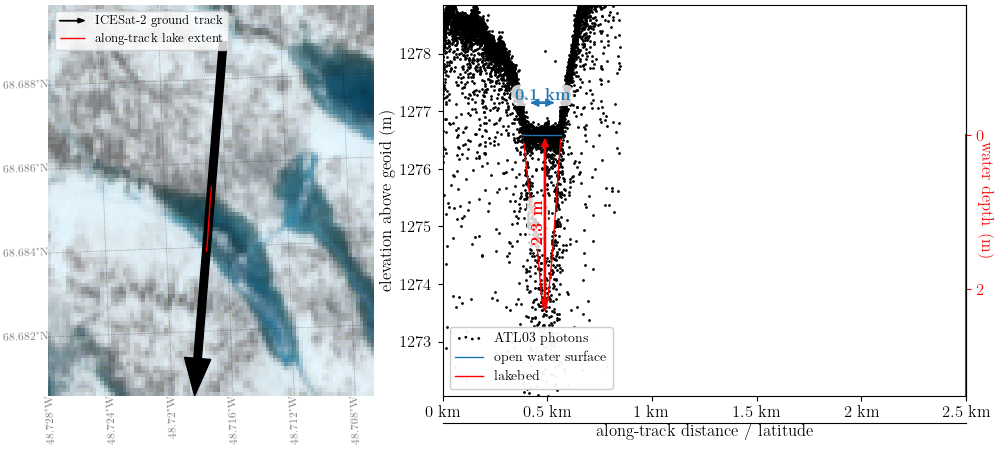

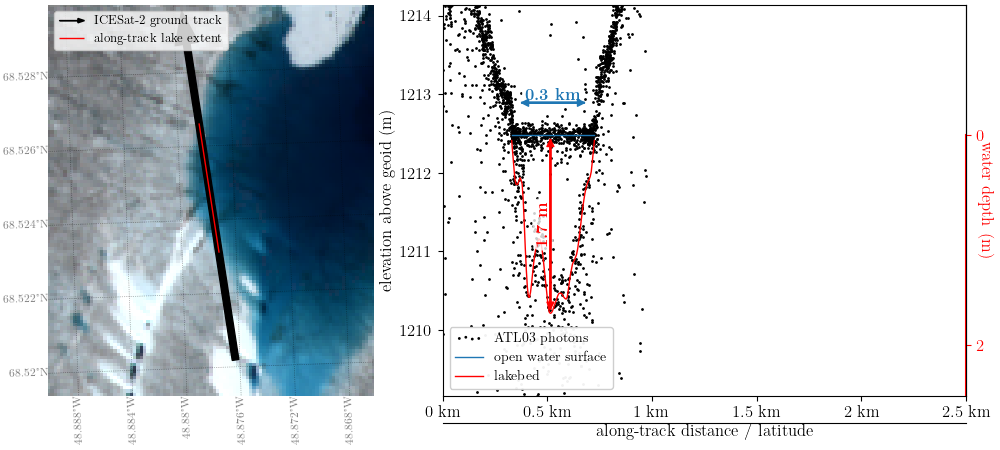

In [13]:
plt.close('all')

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})

settings = {
    're_download': False,
    'img_aspect': 1.2,
    'days_buffer': 5,
    'gamma_value': 1.0,
}

gdfn = gdfl[~gdfl.intersects_with_extent].copy()
gdfn.sort_values(by='lake_quality',ascending=False)[['ice_sheet','melt_season','lake_quality','file_name']]
for i in range(5):
    fn = gdfn.file_name.iloc[i]
    fig = plt.figure(figsize=[10,4.5])
    gs = fig.add_gridspec(ncols=5, nrows=1)
    axs = []
    axs.append(fig.add_subplot(gs[0, :2])) 
    axs.append(fig.add_subplot(gs[0, 2:]))
    toplot = {
        'fn': fn,
        'xlm': [None, None],
        'ylm': [None, None],
        'name': '',
    }
    plot_IS2lake_imagery(**toplot, **settings, axes=axs)
    fig.tight_layout(pad=0.3, h_pad=0.3, w_pad=0.4)

In [ ]:
np.sum(gdfn.lake_quality > 0)

In [ ]:
df = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
regions = ['CW', 'B-C']

min_area = 30*30 / 1e6 * 9

for region in regions:
    
    if region == 'B-C':
        region_name = 'Amery Catchment'
        base_crs = 'EPSG:3031'
        meltseasons = ['2018-19', '2020-21']
    if region == 'CW':
        region_name = 'Central West Greenland'
        base_crs = 'EPSG:3413'
        meltseasons = ['2019', '2020']
    
    dfl = df[df.basin_name == region]
    lakedfs = []
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(base_crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)
    
        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs).buffer(100)
        gdfs['in_ext'] = gdfs.geometry.within(shapely.unary_union(ext))
        # ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        # .explode(index_parts=False).to_crs(base_crs)
        # patch_areas = ext.geometry.area / 1e6
        # ext = ext[patch_areas > min_area].simplify(60)
        # gdfs['in_ext'] = gdfs.geometry.within(shapely.unary_union(ext))

        perc_all = np.sum(gdfs.in_ext) / len(gdfs)
        perc_hqual = np.sum(gdfs.in_ext & (gdfs.lake_quality > 0)) / np.sum(gdfs.lake_quality > 0)
        print(region, meltseason, perc_all, perc_hqual)
        
        lakedfs.append(gdfs)

In [ ]:
dfall = pd.concat(lakedfs)

thisdf = dfall
print(np.sum(thisdf.in_ext) / len(thisdf))
print(np.sum(thisdf.in_ext & (thisdf.lake_quality > 0)) / np.sum(thisdf.lake_quality > 0))

thisdf = dfall[dfall.]

In [ ]:
thisdf = lakedfs[1]
print(np.sum(thisdf.in_ext) / len(thisdf))
print(np.sum(thisdf.in_ext & (thisdf.lake_quality > 0)) / np.sum(thisdf.lake_quality > 0))

In [ ]:
print(ext.area.sum() / 1e6)
print(gre_gdf_thresh.area.sum() / 1e6)
print(ext.area.sum() / gre_gdf_thresh.area.sum())

In [ ]:
print(len(is_inside))
print(np.sum(is_inside))

In [ ]:
df = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
def get_extent_overlap(region, meltseasons):
    if region == 'B-C':
        region_name = 'Amery Catchment'
        base_crs = 'EPSG:3031'
    if region == 'CW':
        region_name = 'Central West Greenland'
        base_crs = 'EPSG:3413'

    dfl = df[df.basin_name == region]
    lakedfs = []
    exts = []
    
    
    for i, meltseason in enumerate(meltseasons):
        dfs = dfl[dfl.melt_season == meltseason]
        gdfs = gpd.GeoDataFrame(dfs, geometry=gpd.points_from_xy(dfs.lon, dfs.lat), crs="EPSG:4326").to_crs(base_crs)
        gdfs['x'] = gdfs.apply(lambda x: x.geometry.x, axis=1)
        gdfs['y'] = gdfs.apply(lambda x: x.geometry.y, axis=1)

        ext = gpd.read_file('region_shapefiles/extents/%s_extent_%s.geojson' % (region,meltseason.replace('-', '_')))\
        .explode(index_parts=False).to_crs(base_crs).buffer(100)
        gdfs['in_ext'] = 
        
        lakedfs.append(gdfs)

In [ ]:
melt_season = '2020-21'
dfs = dfl[dfl.melt_season == melt_season].copy().sort_values(by='depth_95th_pctl', ascending=False)
for i in range(30):
    fn = dfs.iloc[i].file_name
    # fn = 'data/validation/fluidsurrf_out/lake_09989-09335_AIS_2018-19_simplified_ANT_1000_East_B-C_ATL03_20190102184312_00810210_006_02_gt2l_0010.h5'
    d95 = dfs.iloc[i].depth_95th_pctl
    lk = dictobj(read_melt_lake_h5(fn))
    fig, ax = plt.subplots()
    dfd = lk.depth_data
    df = lk.photon_data
    hsurf = lk.surface_elevation
    ax.scatter(df.xatc, df.h - hsurf, s=1, c='k', alpha=0.5)
    sel = dfd.conf > 0.5
    depth = dfd.depth.copy()
    depth[~sel] = np.nan
    ax.plot(dfd.xatc, -depth, 'r-')
    ax.plot(dfd.xatc, -dfd.depth*1.333, color='C1')
    ax.set_ylim((-d95*2, d95*0.5))
    plt.close(fig)
    print('______________________________________________________________________________________')
    print('%s max depth: %.1f' % (melt_season, np.nanmax(depth)))
    print('lake quality: %.2f' % lk.lake_quality)
    print(fn)
    display(fig)
    

In [ ]:
dfhq = dfl[dfl.lake_quality > 0]
dfhq.groupby(by=['ice_sheet','melt_season'])[['depth_95th_pctl']].max()

In [ ]:
for sheet in ['AIS', 'GrIS']:
    sheet_counts.loc[sheet, 'percent'] = sheet_counts.loc[sheet].lake_count / sheet_counts.loc[sheet].lake_count.sum() * 100

In [ ]:
sheet_counts.loc['AIS'].lake_count / sheet_counts.loc['AIS'].lake_count.sum() * 100

In [ ]:
granule_counts = dfl[['granule_id', 'ice_sheet']].groupby(by='granule_id')\
    .count().rename(columns={'ice_sheet': 'count'}).sort_values(by='count', ascending=False)
info = dfl.groupby(by='granule_id')[['ice_sheet', 'melt_season']].first()
count_info =  pd.concat((granule_counts, info), axis=1)
count_info.iloc[:20]

In [ ]:
dfl['granule_gtx'] = dfl.apply(lambda x: x.granule_id[:-3] + '_' + x.gtx, axis=1)
gtx_counts = dfl[['granule_gtx', 'ice_sheet']].groupby(by='granule_gtx')\
    .count().rename(columns={'ice_sheet': 'count'}).sort_values(by='count', ascending=False)
info_gtx = dfl.groupby(by='granule_gtx')[['ice_sheet', 'melt_season']].first()
gtx_counts = pd.concat((gtx_counts, info_gtx), axis=1)

gtx_counts[gtx_counts.melt_season == '2018-19'].iloc[:30]

# Use these granules / gtx for validation:
- ATL03_20190102184312_00810210_006_02_gt2l

In [ ]:
# download ATL03 data from NSIDC
granule_id = 'ATL03_20190102184312_00810210_006_02.h5'
gtx = 'gt2l'
uid, pwd, email = getedcreds()

atl03_dir = 'data/atl03_raw'
fn_atl03 = atl03_dir + '/' + granule_id
fn_valid = atl03_dir + '/' + 'validation_' + granule_id
# geojson = 'geojsons/simplified_GRE_2000_CW.geojson'
geojson = 'geojsons/simplified_ANT_1000_East_B-C.geojson'
if not os.path.isfile(fn_valid):
#if True:
    thisfile, status = download_granule(granule_id, gtxs='all', geojson=geojson, granule_output_path=atl03_dir, 
                                        uid=uid, pwd=pwd, vars_sub='default', spatial_sub=True)
    os.rename(thisfile, fn_valid)
    print(thisfile)

# read in ATL03 data from NSIDC
beams_available, ancillary, dfs, dfs_telem = read_atl03(fn_valid, geoid_h=True, gtxs_to_read=gtx)
df03 = dfs[gtx]

In [ ]:
searchfor = 'ATL03_20190102184312_00810210_006_02_gt2l'
searchdir = 'data/validation/fluidsurrf_out/'
filelist = [searchdir+f for f in os.listdir(searchdir) \
            if os.path.isfile(os.path.join(searchdir, f)) & (searchfor in f) & ('.h5' in f)]
print(len(filelist))

In [ ]:
vars(lk).keys()

In [ ]:
dfds = []
# for i,fn in enumerate(dfl[dfl.granule_gtx=='ATL03_20190102184312_00810210_006_02_gt2l'].file_name):
for i,fn in enumerate(filelist):
    lk = dictobj(read_melt_lake_h5(fn))
    thisdf = lk.depth_data.copy()
    thisdf['lakeid'] = i
    thisdf['lake_quality'] = lk.lake_quality
    thisdf['fn'] = fn
    dfds.append(thisdf)
    # print(fn)
    # fig,ax = plt.subplots()
    # dfp = lk.photon_data
    # ax.scatter(dfp.lat, dfp.)
dfd = pd.concat(dfds)

In [ ]:
fig,ax = plt.subplots(figsize=[9,5])
ax.scatter(df03.lat, df03.h, s=1, c='k')
for dfdepth in dfds:
    ax.plot(dfdepth.lat, dfdepth.h_fit_bed, 'r-')
    ax.plot(dfdepth.lat, dfdepth.h_fit_surf, 'b-')
fig.tight_layout(pad=0)

In [ ]:
print("{'xl': (%.7f, %.7f), 'yl': (%.2f, %.2f), 'qual': }," % tuple(list(ax.get_xlim()) + list(ax.get_ylim())))

In [ ]:
locs = [
    {'xl': (-72.9975630, -72.9886089), 'yl': (201.52, 215.75), 'qual': 2},
    {'xl': (-72.9698436, -72.9544389), 'yl': (200.82, 212.44), 'qual': 2},
    {'xl': (-72.8933728, -72.8766600), 'yl': (190.74, 200.59), 'qual': 2},
    {'xl': (-72.8408549, -72.8372124), 'yl': (187.82, 202.83), 'qual': 2},
    {'xl': (-72.3118863, -72.3027743), 'yl': (110.10, 151.50), 'qual': 2},
    {'xl': (-72.2672962, -72.2582180), 'yl': (121.34, 133.88), 'qual': 2},
    {'xl': (-71.9282961, -71.9263007), 'yl': (93.02, 100.83), 'qual': 2},
    {'xl': (-71.8775898, -71.8661434), 'yl': (68.94, 85.94), 'qual': 2},
    {'xl': (-71.6871403, -71.6840616), 'yl': (11.22, 45.08), 'qual': 2},
    {'xl': (-71.6499030, -71.6359531), 'yl': (54.70, 76.32), 'qual': 2},
    {'xl': (-71.5295575, -71.5269419), 'yl': (89.06, 99.45), 'qual': 2},
    {'xl': (-71.5061186, -71.4941196), 'yl': (96.10, 108.87), 'qual': 2},
    {'xl': (-70.7064828, -70.6999293), 'yl': (13.39, 23.78), 'qual': 2},
    # #
    # {'xl': (-73.9704380, -73.9680810), 'yl': (902.67, 913.98), 'qual': 0},
    # {'xl': (-73.5833913, -73.5805833), 'yl': (706.45, 727.30), 'qual': 0},
    # {'xl': (-73.5554598, -73.5519779), 'yl': (615.50, 631.60), 'qual': 1},
    # {'xl': (-73.3138660, -73.3087011), 'yl': (236.22, 254.69), 'qual': 1},
    # {'xl': (-73.1239353, -73.1197628), 'yl': (230.30, 243.76), 'qual': 1},
    # {'xl': (-72.8563611, -72.8515682), 'yl': (187.67, 202.21), 'qual': 0},
    # {'xl': (-72.3461232, -72.3416983), 'yl': (130.81, 147.51), 'qual': 1},
    # {'xl': (-71.9827610, -71.9749346), 'yl': (98.64, 108.18), 'qual': 1},
    # {'xl': (-71.9634995, -71.9592142), 'yl': (87.94, 109.26), 'qual': 1},
    # {'xl': (-71.9524673, -71.9489281), 'yl': (95.18, 105.38), 'qual': 1},
    # {'xl': (-71.9077563, -71.9046551), 'yl': (92.41, 101.87), 'qual': 1},
    # {'xl': (-71.7020713, -71.6960718), 'yl': (26.85, 46.31), 'qual': 1},
    # {'xl': (-71.5998209, -71.5953100), 'yl': (99.02, 107.49), 'qual': 1},
    # {'xl': (-71.1067250, -71.0998121), 'yl': (176.20, 210.52), 'qual': 1},
    # {'xl': (-70.6961783, -70.6940808), 'yl': (2.76, 20.77), 'qual': 1},
]

In [ ]:
plt.close('all')

In [ ]:
lakes_overlap = []
counter = 0
trackid = 'ATL03_20190102184312_00810210_006_02_gt2l'
for l in locs:
    if l['qual'] > 0:
        fig,ax = plt.subplots(figsize=[7,4])
        df = df03[(df03.lat > l['xl'][0]) & (df03.lat < l['xl'][1]) & (df03.h > l['yl'][0]) & (df03.h < l['yl'][1])]
        dfdp = dfd[(dfd.lat > l['xl'][0]) & (dfd.lat < l['xl'][1])].copy()
        dfdp.loc[dfdp.conf < 0.3, 'h_fit_bed'] = np.nan
        ax.scatter(df.lat, df.h, s=1, c='k')
        ax.plot(dfdp.lat, dfdp.h_fit_surf, color='C0')
        ax.plot(dfdp.lat, dfdp.h_fit_bed, color='C1')

        if len(dfdp) > 0: 
            lake_quality = dfdp.lake_quality.mean()
            lakes_overlap += list(np.unique(dfdp.lakeid))
            ax.text(0.5, 0.98, 'found by FLUID and manually\nSuRRF quality: %.2f' %lake_quality, transform=ax.transAxes, 
                    fontsize=14, color='g', ha='center', va='top', fontweight='bold')
            thisfn = dfdp.fn.iloc[0]
            print(thisfn)
            print(dfdp.lat.mean())
        else:
            ax.text(0.5, 0.98, 'found manually but not by FLUID', transform=ax.transAxes, fontsize=14, color='r', ha='center', va='top', fontweight='bold')
        
        fig.tight_layout(pad=0)
        counter += 1
        fig.savefig('zzz_evalplots/' + trackid + '_%03d.jpg' % counter, dpi=300)
        plt.close(fig)
        display(fig)
        print('__________________________________________________________________')

for i in np.unique(dfd.lakeid):
    if i not in lakes_overlap:
        dfdp = dfd[dfd.lakeid == i].copy()
        lake_quality = dfdp.lake_quality.mean()
        dfdp.loc[dfdp.conf < 0.3, 'h_fit_bed'] = np.nan
        hrange = dfdp.h_fit_surf.max() - dfdp.h_fit_bed.min()
        hmin = dfdp.h_fit_bed.min() - hrange
        hmax = dfdp.h_fit_bed.max() + hrange
        df = df03[(df03.lat > dfdp.lat.min()) & (df03.lat < dfdp.lat.max()) & (df03.h > hmin) & (df03.h < hmax)]
        fig,ax = plt.subplots(figsize=[7,4])
        ax.scatter(df.lat, df.h, s=1, c='k')
        ax.plot(dfdp.lat, dfdp.h_fit_surf, color='C0')
        ax.plot(dfdp.lat, dfdp.h_fit_bed, color='C1')
        ax.text(0.5, 0.98, 'found by FLUID but not manually\nSuRRF quality: %.2f' % lake_quality, 
                transform=ax.transAxes, fontsize=14, color='b', ha='center', va='top', fontweight='bold')
        fig.tight_layout(pad=0)
        counter += 1
        fig.savefig('zzz_evalplots/' + trackid + '_%03d.jpg' % counter, dpi=300)
        plt.close(fig)
        display(fig)
        print('__________________________________________________________________')

In [ ]:
# df_lakes = df.copy()
# maxdepths = []
# for i in range(len(df_lakes)):
# # for i in range(100):
#     print('reading file %5i / %5i' % (i+1, len(df_lakes)), end='\r')
#     fn = df_lakes.iloc[i].file_name
#     lk = dictobj(read_melt_lake_h5(fn))
#     dfd = lk.depth_data.copy()
    
#     isdepth = dfd.depth>0
#     bed = dfd.h_fit_bed
#     bed[~isdepth] = np.nan
#     bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
#     bed[dfd.depth<0.9] = np.nan
#     surf = np.ones_like(dfd.xatc) * lk.surface_elevation
#     surf[~isdepth] = np.nan
#     bed_only = bed[(~np.isnan(surf)) & (~np.isnan(bed))]

#     if len(bed_only) == 0:
#         maxdepths.append(np.nan)
#     else:
#         y_low = np.percentile(bed_only, 5)
#         y_up = lk.surface_elevation
#         ref_index = 1.33
#         max_depth = (y_up - y_low) / ref_index
#         maxdepths.append(max_depth)

# df_lakes['depth_95th_pctl'] = maxdepths
# df_lakes.to_csv('data/lakestats_methods_paper_depth_update.csv', index=False)
# df_lakes

In [ ]:
df_lakes = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
# df_lakes = df_lakes[df_lakes.quality_summary > 0]

In [ ]:
plt.rcParams.update({
    'font.size': 12,
    'text.usetex': True,
    'font.family': 'Optima'
})
colors = {
    'GrIS': '#D00C33', # Greenland flag
    'AIS': '#3A7DCE' # Antarctica, Graham Bartram Design
}
line_sty = {
    'low_melt': '--',
    'high_melt': '-'
}

season_type = {
    '2018-19': 'high_melt',
    '2020-21': 'low_melt',
    '2019': 'high_melt',
    '2020': 'low_melt'
}

melt_seasons = [
    '2018-19',
    '2020-21',
    '2019', 
    '2020',
]

density = True
collapse = True
collapse_start = 6
collapse_factor = 5

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

fig, ax = plt.subplots(figsize=[6,4], dpi=100)
step = 0.25
step_s = 0.1
smooth = 1
uplim = 25
bins = np.arange(0,uplim+step/2,step)
mids = bins[:-1] + np.diff(bins)/2
bins_s = np.arange(0,uplim+step_s-0.1,step_s)
mids_s = bins_s[:-1] + np.diff(bins_s)/2
wdw = int(np.ceil(smooth/step_s))

if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor

hdls = []
maxval = 0
medians = []
for melt_season in melt_seasons:
    sheet = 'AIS' if len(melt_season)>4 else 'GrIS'
    dfi = df_lakes[(df_lakes.melt_season == melt_season) & (~np.isnan(df_lakes.depth_95th_pctl))]
    sheet_name = 'Antarctic Ice Sheet' if sheet=='AIS' else 'Greenland Ice Sheet'
    print('%4s %7s: %4i %5.2f %5.2f %5.2f' % (
        sheet, 
        melt_season, 
        len(dfi), 
        dfi.depth_95th_pctl.mean(), 
        dfi.depth_95th_pctl.median(), 
        dfi.depth_95th_pctl.max()))
    medians.append(dfi.depth_95th_pctl.median())
    depths = np.clip(dfi.depth_95th_pctl, 0, uplim-step/2)
    
    hist = np.histogram(depths, bins=bins, density=density)[0]
    hist_s = np.histogram(depths, bins=bins_s, density=density)[0]
    
    hist_smooth = pd.Series(hist_s).rolling(window=wdw*3, center=True, min_periods=1, win_type='gaussian').mean(std=wdw/2)
    # hdl = ax.bar(mids, hist, np.diff(bins)[0], color=colors[sheet], alpha=0.3, label=sheet_name)
    # hdls.append(hdl)

    coladj = 1.3
    amt = coladj if season_type[melt_season] == 'high_melt' else 1/coladj
    thiscol = adjust_lightness(colors[sheet], amount=amt)
    hdl, = ax.plot(mids_s, hist_smooth, color=thiscol, lw=1.0, alpha=1.0,
                   label='%s, %s (%s)'%(sheet,melt_season,season_type[melt_season].replace('_', ' ')), 
                   ls=line_sty[season_type[melt_season]])
    ax.fill_between(mids_s, hist_smooth, color=thiscol, alpha=0.15)
    hdls.append(hdl)
    median = dfi.depth_95th_pctl.median()
    hdl, = ax.plot([median]*2, [0,100], lw=0.7, color=thiscol, 
                   label = 'median: %.2f m' % median,
                   ls=line_sty[season_type[melt_season]], zorder=-100)
    hdls.append(hdl)
    maxval = np.max((maxval, np.max(hist_smooth)))

if collapse:
    ax.set_xticks(coll_ticks)
    ax.set_xticklabels(coll_ticklabels)
    ax.set_xticks(minor_ticks, minor=True)

if density:
    ax.set_ylabel('distribution density')
else:
    ax.set_ylabel('number of lakes per %g m depth bin')
    
ax.set_xlabel('maximum along-track lake depth (m)')
ax.set_xlim((0,np.max(mids_s)))
ax.set_ylim((-0.001, 1.1*maxval))
ax.tick_params(axis='both')

ax.legend(handles=hdls)
fig.tight_layout()

if density:
    fn_plot_out = 'plots/depth_distributions_density.jpg'
else:
    fn_plot_out = 'plots/depth_distributions_counts.jpg'
if collapse:
    fn_plot_out = fn_plot_out.replace('.jpg', '_collapsed.jpg')
fig.savefig(fn_plot_out, dpi=600)

In [ ]:
if collapse: 
    mids_s[mids_s > collapse_start] = collapse_start + (mids_s[mids_s > collapse_start]-collapse_start) / collapse_factor
    coll_labs = np.array([5,10,15,20,25])
    coll_labs = coll_labs[coll_labs > collapse_start]
    coll_ticks = np.arange(0,collapse_start+1)
    coll_ticklabels = np.hstack((coll_ticks, coll_labs))
    coll_ticks = np.hstack((coll_ticks, collapse_start+((coll_labs-collapse_start)/collapse_factor)))
    minor_ticks = np.arange(0, uplim+1).astype(np.float64)
    minor_ticks[minor_ticks > collapse_start] = collapse_start + (minor_ticks[minor_ticks > collapse_start]-collapse_start) / collapse_factor
print(['%4g' % x for x in coll_ticks])
print(['%4g' % x for x in coll_ticklabels])
print(minor_ticks)

In [ ]:
dfi = pd.read_csv('data/lakestats_methods_paper_depth_update.csv')
dfi = dfi.sort_values(by='depth_95th_pctl', ascending=False)
for i in [0]:
    fn = dfi.iloc[i].file_name
    print(fn)
    lk = dictobj(read_melt_lake_h5(fn))
    df = lk.photon_data
    dfd = lk.depth_data.copy()
    
    isdepth = dfd.depth>0
    bed = dfd.h_fit_bed
    bed[~isdepth] = np.nan
    bed[(dfd.depth>2) & (dfd.conf < 0.3)] = np.nan
    surf = np.ones_like(dfd.xatc) * lk.surface_elevation
    surf[~isdepth] = np.nan
    bed[np.isnan(surf)] = np.nan
    
    fig, ax = plt.subplots(figsize=[6,6], dpi=100)
    ax.scatter(df.xatc, df.h, s=1, c='k')
    # ax.plot(dfd.xatc, bed, 'r-')
    
    # ax.scatter(dfd.xatc, bed, s=5, c='r', alpha=dfd.conf)
    alph = np.array(dfd.conf)
    alph[alph<0.5] = 0.0
    ax.scatter(dfd.xatc, bed, s=5, color='r', alpha=alph)